### library import

In [1]:
import numpy as np
import pandas as pd
import scipy.misc as scm
from scipy.stats import poisson
import scipy.integrate as integrate
from scipy import signal
import math
import random
from decimal import *
from numba.decorators import jit
from functools32 import lru_cache
import time

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

### theory.py

In [22]:
@lru_cache(maxsize=None)
def poisson_probability(n, t, lambda_poisson):
    return math.e**(-lambda_poisson * t) * (lambda_poisson * t)**n / math.factorial(n)

@lru_cache(maxsize=None)
def gamma_probability(n, t, lambda_poisson):
    return lambda_poisson**n * t**(n - 1) * math.e**(-lambda_poisson * t) / math.factorial(n - 1)

@lru_cache(maxsize=None)
def g(m, n, t, T, lambda_poisson):
    return lambda_poisson**n * t**(m - 1) * (T - t)**(n - m) * math.e**(-lambda_poisson * T) / (math.factorial(m - 1) * math.factorial(n - m))

@lru_cache(maxsize=None)
def acc_odd(n, p):
    i = int((n + 1) / 2)
    acc = 0
    for j in range(i):
        acc += scm.comb(2 * i - 1, j) * p**(2 * i - 1 - j) * (1 - p)**j
    return acc

@lru_cache(maxsize=None)
def acc_even(n, p):
    i = int(n / 2)
    acc = 0
    for j in range(i):
        acc += scm.comb(2 * i, j) * p**(2 * i - j) * (1 - p)**j
    acc += scm.comb(2 * i, i) * p**i * (1 - p)**i / 2
    return acc

@lru_cache(maxsize=None)
def acc(n, p):
    if n % 2 == 1:
        return acc_odd(n, p)
    else:
        return acc_even(n, p)

# tまでに平均 t * lambda人到着するので、無限人まで繰り返したいが不可能なので t * lambda * 1.8回繰り返す
@lru_cache(maxsize=None)
def time_priority_method(t, w, p, lambda_poisson):
    if t == 0: return 0
    return np.sum(poisson_probability(i, t, lambda_poisson) * acc(i, p) for i in range(1, int(1.8 * t * lambda_poisson))) - w * t

@lru_cache(maxsize=None)
def max_time_priority(w, p, lambda_poisson):
    value_down = time_priority_method(1, w, p, lambda_poisson)
    for t in range(2, 100000):
            value_up = time_priority_method(t, w, p, lambda_poisson)
            if (value_up - value_down) <= 0: return value_down
            value_down = value_up

@lru_cache(maxsize=None)
def max_time_priority_with_error(w, p, p_error, lambda_poisson, lambda_poison_error):
    value_down = time_priority_method(1, w, p, lambda_poisson)
    for t in range(2, 100000):
            value_up = time_priority_method(t, w, p, lambda_poisson)
            if (value_up - value_down) <= 0:
                return time_priority_method(t - 1, w, p + p_error, lambda_poisson + lambda_poison_error)
            value_down = value_up

@lru_cache(maxsize=None)
def poll_priority_method(n, w, p, lambda_poisson):
    if n == 0: return 0
    return acc(n, p) - w * n / lambda_poisson

@lru_cache(maxsize=None)
def max_poll_priority(w, p, lambda_poisson):
    value_down = poll_priority_method(1, w, p, lambda_poisson)
    for n in range(1, 100000):
            value_up = poll_priority_method(2 *n + 1, w, p, lambda_poisson)
            if (value_up - value_down) <= 0: return value_down
            value_down = value_up

@lru_cache(maxsize=None)
def max_poll_priority_with_error(w, p, p_error, lambda_poisson, lambda_poison_error):
    value_down = poll_priority_method(1, w, p, lambda_poisson)
    for n in range(1, 100000):
            value_up = poll_priority_method(2 * n + 1, w, p, lambda_poisson)
            if (value_up - value_down) <= 0:
                return poll_priority_method(2 * n - 1, w, p + p_error, lambda_poisson + lambda_poison_error)
            value_down = value_up

@lru_cache(maxsize=None)
def vote_priority_method(k, w, p, lambda_poisson):
    if k == 0: return 0
    utility = 0
    for j in range(k, 2 * k):
        value = w * j / lambda_poisson
        utility += (scm.comb(j - 1, j - k) * p**(k - 1) * (1 - p)**(j - k) * p * (1 - value)) + (scm.comb(j - 1, j - k) * p**(j - k) * (1 - p)**(k - 1) * (1 - p) * -value )
    return utility

@lru_cache(maxsize=None)
def max_vote_priority(w, p, lambda_poisson):
    value_down = vote_priority_method(1, w, p, lambda_poisson)
    for k in range(2, 100000):
            value_up = vote_priority_method(k, w, p, lambda_poisson)
            if (value_up - value_down) <= 0: return  value_down
            value_down = value_up

@lru_cache(maxsize=None)
def max_vote_priority_with_error(w, p, p_error, lambda_poisson, lambda_poison_error):
    value_down = vote_priority_method(1, w, p, lambda_poisson)
    for k in range(2, 100000):
            value_up = vote_priority_method(k, w, p, lambda_poisson)
            if (value_up - value_down) <= 0:
                return vote_priority_method(k - 1, w, p + p_error, lambda_poisson + lambda_poison_error)
            value_down = value_up

@lru_cache(maxsize=None)
def not_stop_by_T1(T1, n, w, p, lambda_poisson):
    return np.sum(poisson_probability(i, T1, lambda_poisson) * (acc(i, p) - w * T1) for i in range(0, n))

@lru_cache(maxsize=None)
def stop_by_T1(T1, n, w, p, lambda_poisson):
    return integrate.quad(lambda t: (acc(n, p) - w * t) * gamma_probability(n, t, lambda_poisson), 0, T1)[0]

@lru_cache(maxsize=None)
def method1(T1, n, w, p, lambda_poisson):
    if n == 0: return 0
    return not_stop_by_T1(T1, n, w, p, lambda_poisson) + stop_by_T1(T1, n, w, p, lambda_poisson)

# 返り値は最大の効用とその時のT1のリスト
@lru_cache(maxsize=None)
def max_method1(w, p, lambda_poisson):
    max_utility = 0
    T1_range = range(1, 10000)
    for t1 in T1_range:
        value_down = method1(t1, 1, w, p, lambda_poisson)
        for n in range(1, 10000):
                value_up = method1(t1, 2 * n + 1, w, p, lambda_poisson)
                if (value_up - value_down) <= 0:
                    if value_down > max_utility:
                        max_utility = value_down
                        break
                    else:
                        return [max_utility, t1]
                value_down = value_up

@lru_cache(maxsize=None)
def max_method1_with_error(w, p, p_error, lambda_poisson, lambda_poison_error):
    max_utility = 0
    param_arr = np.array((0, 0)) # [0] => T1, [1] => n
    T1_range = range(1, 10000)
    for t1 in T1_range:
        value_down = method1(t1, 1, w, p, lambda_poisson)
        for n in range(1, 10000):
                value_up = method1(t1, 2 * n + 1, w, p, lambda_poisson)
                if (value_up - value_down) <= 0:
                    if value_down > max_utility:
                        max_utility = value_down
                        param_arr = np.array((t1, 2 * n - 1))
                    else:
                        return [method1(param_arr[0], param_arr[1], w, p + p_error, lambda_poisson + lambda_poison_error), t1]
                    break
                value_down = value_up

@lru_cache(maxsize=None)
def integrate_for_method2_1(T1, T2, n, w, p, lambda_poisson, i):
    return integrate.quad(lambda t: (acc(n, p) - w * t) * g(n, i, t, T1, lambda_poisson), 0, T2)[0]

@lru_cache(maxsize=None)
def integrate_for_method2_2(T1, T2, n, w, p, lambda_poisson, i):
    return integrate.quad(lambda t: (acc(n, p) - w * T1) * g(n, i, t, T1, lambda_poisson), T2, T1)[0]

# T1までに平均 T1 * lambda人到着するので、無限人まで繰り返したいが不可能なので T1 * lambda * 1.8回繰り返す
@lru_cache(maxsize=None)
def method2(T1, T2, n, w, p, lambda_poisson):
    if n == 0: return 0
    return not_stop_by_T1(T1, n, w, p, lambda_poisson) \
     + np.sum(integrate_for_method2_1(T1, T2, n, w, p, lambda_poisson, i) \
     + integrate_for_method2_2(T1, T2, n, w, p, lambda_poisson, i) for i in range(n,int(T1 * lambda_poisson * 1.8)))

# utl_errorが0に近付けば近くほどutilityは正確になる(0.00001くらいでよい)
# T1はmethod1と同じモノを用いる
@lru_cache(maxsize=None)
def max_method2(w, p, lambda_poisson, utl_error):
    max_utility = 0
    t1 = max_method1(w, p, lambda_poisson)[1]
    for t2 in range(1, t1 + 1):
        value_down = method2(t1, t2, 1, w, p, lambda_poisson)
        for n in range(1, 10000):
            value_up = method2(t1, t2, 2 * n + 1, w, p, lambda_poisson)
            if value_up - value_down <= utl_error:
                if value_down -  max_utility > utl_error:
                    max_utility = value_down
                    break
                else:
                    return [max_utility, t1, t2]
            value_down = value_up

# utl_errorが0に近付けば近くほどutilityは正確になる(0.00001くらいでよい)
# T1はmethod1と同じモノを用いる
@lru_cache(maxsize=None)
def max_method2_with_error(w, p, p_error, lambda_poisson, lambda_poison_error, utl_error):
    max_utility = 0
    param_arr = np.array((0, 0, 0)) # [0] => T1, [1] => T2, [2] => n
    t1 = max_method1_with_error(w, p, 0, lambda_poisson, 0)[1]
    for t2 in range(1, t1 + 1):
        value_down = method2(t1, t2, 1, w, p, lambda_poisson)
        for n in range(1, 10000):
            value_up = method2(t1, t2, 2 * n + 1, w, p, lambda_poisson)
            if value_up - value_down <= utl_error:
                if value_down - max_utility > utl_error:
                    max_utility = value_down
                    param_arr = np.array((t1, t2, 2 * n - 1))
                    break
                else:
                    return method2(param_arr[0], param_arr[1], param_arr[2], w, p + p_error, lambda_poisson + lambda_poison_error)
            value_down = value_up

# WIP
@lru_cache(maxsize=None)
def method3(T1, k, w, p, lambda_poisson):
    if k == 0: return 0
    utility = 0
    for j in range(k, 2 * k):
        # 積分を行う
        value_1 = integrate.quad(lambda t: w * t * gamma_probability(j, t, lambda_poisson), 0, T1)[0]
        # ----被積分関数を定義----
        @lru_cache(maxsize=None)
        def integrand_for_method3(t):
            integrand = 0
            for l in range(0, j):
                p_sum = 0
                for m in range(0, j):
                    p_sum += poisson_probability(m, T1, lambda_poisson)
                integrand += ((poisson_probability(l, T1, lambda_poisson) * acc(l, p) / p_sum)  - w * T1)
            return integrand * gamma_probability(j, t, lambda_poisson)
        # --------終わり--------
        value_2, abserr = integrate.quad(integrand_for_method3, T1, np.inf)
        utility += scm.comb(j - 1, j - k) * p**(k - 1) * (1 - p)**(j - k) * p * (1 - value_1 + value_2)
        utility += scm.comb(j - 1, j - k) * p**(j - k) * (1 - p)**(k - 1) * (1 - p) * (-value_1 + value_2)
    return utility

# ------------グラフをプロットするメソッド------------
# ------------グラフをプロットするメソッド------------
@lru_cache(maxsize=None)
def plot_poisson(time, lambda_poisson):
    x_axis = np.linspace(0, 2 * time * lambda_poisson, 2 * time * lambda_poisson + 1)
    y_axis = [poisson_probability(x, time, lambda_poisson) for x in x_axis]
    plt.title('poisson time: {0} lambda: {1}'.format(time, lambda_poisson))
    plt.xlabel('people')
    plt.ylabel('probability')
    plt.plot(x_axis, y_axis)
    plt.savefig("poisson.png")
    plt.show()

@lru_cache(maxsize=None)
def plot_gamma(people, lambda_poisson):
    x_axis = np.linspace(0, 2 * people / lambda_poisson , 10 * people / lambda_poisson)
    y_axis = [gamma_probability(people, x, lambda_poisson) for x in x_axis]
    plt.title('gamma people: {0} lambda: {1}'.format(people, lambda_poisson))
    plt.xlabel('time')
    plt.ylabel('probability')
    plt.plot(x_axis, y_axis)
    plt.savefig("gamma.png")
    plt.show()

@lru_cache(maxsize=None)
def plot_g(m, n, T, lambda_poisson):
    x_axis = np.linspace(0, T, T + 1)
    y_axis = [g(m, n, x, T, lambda_poisson) for x in x_axis]
    plt.title("g m: {0} n: {1} T:{2} lambda: {3}".format(m, n, T, lambda_poisson))
    plt.xlabel('time')
    plt.ylabel('probability')
    plt.plot(x_axis, y_axis)
    plt.savefig("g.png")
    plt.show()

@lru_cache(maxsize=None)
def plot_time_priority(w, p, lambda_poisson, s_time, t_time):
    x_axis = np.linspace(s_time, t_time, t_time - s_time + 1)
    y_axis = [time_priority_method(int(x), w, p, lambda_poisson) for x in x_axis]
    plt.title('time priority method weight: {0} person_probability: {1} lambda_poisson: {2}'.format(w, p, lambda_poisson))
    plt.xlabel('time')
    plt.ylabel('utility')
    plt.plot(x_axis, y_axis)
    plt.savefig("time_priority.png")
    plt.show()

@lru_cache(maxsize=None)
def plot_poll_priority(w, p, lambda_poisson, s_time, t_time):
    x_axis = np.linspace(s_time, t_time, t_time - s_time + 1)
    y_axis = [poll_priority_method(int(x), w, p, lambda_poisson) for x in x_axis]
    plt.title('poll priority method weight: {0} person_probability: {1} lambda_poisson: {2}'.format(w, p, lambda_poisson))
    plt.xlabel('poll people')
    plt.ylabel('utility')
    plt.plot(x_axis, y_axis)
    plt.savefig("poll_priority.png")
    plt.show()

@lru_cache(maxsize=None)
def plot_vote_priority(w, p, lambda_poisson, s_time, t_time):
    x_axis = np.linspace(s_time, t_time, t_time - s_time + 1)
    y_axis = [vote_priority_method(int(x), w, p, lambda_poisson) for x in x_axis]
    plt.title('vote priority method weight: {0} person_probability: {1} lambda_poisson: {2}'.format(w, p, lambda_poisson))
    plt.xlabel('require vote people')
    plt.ylabel('utility')
    plt.plot(x_axis, y_axis)
    plt.savefig("vote_priority.png")
    plt.show()

@lru_cache(maxsize=None)
def plot_method1(w, p, lambda_poisson, s_time, t_time):
    T1 = max_method1(w, p, lambda_poisson)[1]
    x_axis = np.linspace(s_time, t_time, t_time - s_time + 1)
    y_axis = [method1(T1,int(x), w, p, lambda_poisson) for x in x_axis]
    plt.title('method1 T1: {0} weight: {1} person_probability: {2} lambda_poisson: {3}'.format(T1, w, p, lambda_poisson))
    plt.xlabel('poll people')
    plt.ylabel('utility')
    plt.plot(x_axis, y_axis)
    plt.savefig("method1.png")
    plt.show()

@lru_cache(maxsize=None)
def plot_method2(w, p, lambda_poisson, s_time, t_time):
    max_method2_arr = max_method2(w, p, lambda_poisson, 0.0001)
    T1 = max_method2_arr[1]
    T2 = max_method2_arr[2]
    x_axis = np.linspace(s_time, t_time, t_time - s_time + 1)
    y_axis = [method2(T1, T2, int(x), w, p, lambda_poisson) for x in x_axis]
    plt.title('method2 T1: {0} T2: {1} weight: {2} person_probability: {3} lambda_poisson: {4}'.format(T1, T2, w, p, lambda_poisson))
    plt.xlabel('poll people')
    plt.ylabel('utility')
    plt.plot(x_axis, y_axis)
    plt.savefig("method2.png")
    plt.show()

@lru_cache(maxsize=None)
def plot_method3(T1, w, p, lambda_poisson, s_time, t_time):
    x_axis = np.linspace(s_time, t_time, t_time - s_time + 1)
    y_axis = [method3(T1,int(x), w, p, lambda_poisson) for x in x_axis]
    plt.title('method3 T1: {0} weight: {1} person_probability: {2} lambda_poisson: {3}'.format(T1, w, p, lambda_poisson))
    plt.xlabel('require vote people')
    plt.ylabel('utility')
    plt.plot(x_axis, y_axis)
    plt.savefig("method3.png")
    plt.show()

# 横軸 実際のp, 縦軸 utility
@lru_cache(maxsize=None)
def plot_method_utility_with_p_error(w, predicted_p, predicted_lambda_poisson, lambda_poison_error):
    x_axis = np.linspace(0.51, 0.99, 49)
    time_priority_axis = [max_time_priority_with_error(w, predicted_p, p - predicted_p, predicted_lambda_poisson, lambda_poison_error) for p in x_axis]
    poll_priority_axis = [max_poll_priority_with_error(w, predicted_p, p - predicted_p, predicted_lambda_poisson, lambda_poison_error) for p in x_axis]
    vote_priority_axis = [max_vote_priority_with_error(w, predicted_p, p - predicted_p, predicted_lambda_poisson, lambda_poison_error) for p in x_axis]
    method2_axis = [max_method2_with_error(1, 50, w, predicted_p, p - predicted_p, predicted_lambda_poisson, lambda_poison_error) for p in x_axis]
    method3_axis = [max_method3_with_error(15, 30, w, predicted_p, p - predicted_p, predicted_lambda_poisson, lambda_poison_error) for p in x_axis]
    plt.title('method utility with p error w: {0} predicted_p: {1} predicted_lambda: {2} lambda_error: {3}'.format(w, predicted_p, predicted_lambda_poisson, lambda_poison_error))
    plt.xlabel('actual p')
    plt.ylabel('utility')
    plt.plot(x_axis, time_priority_axis, label="time priority")
    plt.plot(x_axis, poll_priority_axis, label="poll priority")
    plt.plot(x_axis, vote_priority_axis, label="vote priority")
    plt.plot(x_axis, method2_axis, label="method2")
    plt.plot(x_axis, method3_axis, label="method3")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.savefig("method_utility_with_p_error.png")
    plt.show()

# 横軸 実際のlambda, 縦軸 utility
@lru_cache(maxsize=None)
def plot_method_utility_with_lambda_poisson_error(w, predicted_p, p_error, predicted_lambda_poisson):
    x_axis = np.linspace(0, 5, 10)
    time_priority_axis = [max_time_priority_with_error(w, predicted_p, p_error, predicted_lambda_poisson, lambda_poisson - predicted_lambda_poisson) for lambda_poisson in x_axis]
    poll_priority_axis = [max_poll_priority_with_error(w, predicted_p, p_error, predicted_lambda_poisson, lambda_poisson - predicted_lambda_poisson) for lambda_poisson in x_axis]
    vote_priority_axis = [max_vote_priority_with_error(w, predicted_p, p_error, predicted_lambda_poisson, lambda_poisson - predicted_lambda_poisson) for lambda_poisson in x_axis]
    method2_axis = [max_method2_with_error(1, 50, w, predicted_p, p_error, predicted_lambda_poisson, lambda_poisson - predicted_lambda_poisson) for lambda_poisson in x_axis]
#     method3_axis = [max_method3_with_error(15, 30, w, p, p_error, predicted_lambda_poisson, lambda_poisson - predicted_lambda_poisson) for lambda_poisson in x_axis]
    plt.title('method utility with lambda error w: {0} predicted_p: {1} p_error: {2} predicted_lambda: {3}'.format(w, predicted_p, p_error, predicted_lambda_poisson))
    plt.xlabel('actual lambda')
    plt.ylabel('utility')
    plt.plot(x_axis, time_priority_axis, label="time priority")
    plt.plot(x_axis, poll_priority_axis, label="poll priority")
    plt.plot(x_axis, vote_priority_axis, label="vote priority")
    plt.plot(x_axis, method2_axis, label="method2")
#     plt.plot(x_axis, method3_axis, label="method3")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.savefig("method_utility_with_lambda_poisson_error.png")
    plt.show()

@lru_cache(maxsize=None)
def plot_best_method(w, p_error, lambda_error):
    color_list = []
    lambda_range = np.linspace(1, 5, 8)
    p_range = np.linspace(0.6, 0.9, 8)
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.set_title('best method plot w: {0} p_error: {1} lambda_error: {2}'.format(w, p_error, lambda_error))
    ax.set_xlabel('predicted p')
    ax.set_ylabel('predicted lambda')
    for p_i in range(len(p_range)):
        for l_i in range(len(lambda_range)):
            max_utility_dict = {
                "red": max_time_priority_with_error(w, p_range[p_i], p_error, lambda_range[l_i], lambda_error),
                "yellow": max_poll_priority_with_error(w, p_range[p_i], p_error, lambda_range[l_i], lambda_error),
                "blue": max_vote_priority_with_error(w, p_range[p_i], p_error, lambda_range[l_i], lambda_error),
                "gray": max_method2_with_error(1, 30, w, p_range[p_i], p_error, lambda_range[l_i], lambda_error),
                "black": max_method3_with_error(24, 26, w, p_range[p_i], p_error, lambda_range[l_i], lambda_error)
            }
            ax.scatter(p_range[p_i], lambda_range[l_i], marker='s', s=150, c=max(max_utility_dict.items(), key=lambda x:x[1])[0], alpha=0.7)
    fig.savefig("best_method.png")
    fig.show()


### plotgraph

------------- Plot graph ---------------


/Users/kotaro/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in double_scalars
/Users/kotaro/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in double_scalars
/Users/kotaro/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars
/Users/kotaro/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


KeyboardInterrupt: 

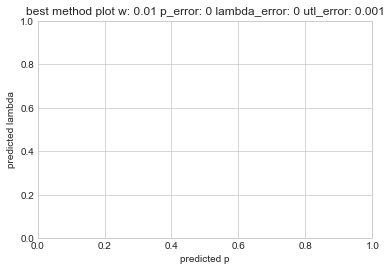

In [8]:
print "------------- Plot graph ---------------"
w = 0.01
p = 0.65
p_error = 0
lambda_poisson = 1
lambda_poisson_error = 0.2

@lru_cache(maxsize=None)
def plot_best_method(w, p_error, lambda_error, utl_error):
    color_list = []
    lambda_range = np.linspace(0, 5, 10)
    p_range = np.linspace(0.5, 1.0, 10)
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.set_title('best method plot w: {0} p_error: {1} lambda_error: {2} utl_error: {3}'.format(w, p_error, lambda_error, utl_error))
    ax.set_xlabel('predicted p')
    ax.set_ylabel('predicted lambda')
    for p_i in range(len(p_range)):
        for l_i in range(len(lambda_range)):
            max_utility_dict = {
                "red": max_time_priority_with_error(w, p_range[p_i], p_error, lambda_range[l_i], lambda_error),
                "yellow": max_poll_priority_with_error(w, p_range[p_i], p_error, lambda_range[l_i], lambda_error),
                "blue": max_vote_priority_with_error(w, p_range[p_i], p_error, lambda_range[l_i], lambda_error),
                "gray": max_method2_with_error(w, p_range[p_i], p_error, lambda_range[l_i], lambda_error)[0],
                "black": max_method3_with_error(w, p_range[p_i], p_error, lambda_range[l_i], lambda_error, utl_error)
            }
            ax.scatter(p_range[p_i], lambda_range[l_i], marker='s', s=150, c=max(max_utility_dict.items(), key=lambda x:x[1])[0], alpha=0.7)
    fig.show()

%time plot_best_method(0.01, 0, 0, 0.001)

In [60]:
print "------------- Plot graph ---------------"
sns.set_style("whitegrid")
w = 0.01
p = 0.6
p_error = 0
lambda_poisson = 1.5
lambda_poisson_error = 0

# print max_poll_priority(w, p, lambda_poisson)
# print max_method2(1, 30, w, p, lambda_poisson)
# print max_method3(28, 30, w, p, lambda_poisson)

# 横軸 実際のp, 縦軸 utility
@lru_cache(maxsize=None)
def plot_method_utility_with_p_error(w, predicted_p, predicted_lambda_poisson, lambda_poison_error):
    x_axis = np.linspace(0.51, 0.99, 49)
    time_priority_axis = [max_time_priority_with_error(w, predicted_p, p - predicted_p, predicted_lambda_poisson, lambda_poison_error) for p in x_axis]
    poll_priority_axis = [max_poll_priority_with_error(w, predicted_p, p - predicted_p, predicted_lambda_poisson, lambda_poison_error) for p in x_axis]
    vote_priority_axis = [max_vote_priority_with_error(w, predicted_p, p - predicted_p, predicted_lambda_poisson, lambda_poison_error) for p in x_axis]
    method2_axis = [max_method2_with_error(1, 10000, w, predicted_p, p - predicted_p, predicted_lambda_poisson, lambda_poison_error) for p in x_axis]
#     method3_axis = [max_method3_with_error(15, 30, w, predicted_p, p - predicted_p, predicted_lambda_poisson, lambda_poison_error) for p in x_axis]
    plt.title('method utility with p error w: {0} predicted_p: {1} predicted_lambda: {2} lambda_error: {3}'.format(w, predicted_p, predicted_lambda_poisson, lambda_poison_error))
    plt.xlabel('actual p')
    plt.ylabel('utility')
    plt.plot(x_axis, time_priority_axis, label="time priority")
    plt.plot(x_axis, poll_priority_axis, label="poll priority")
    plt.plot(x_axis, vote_priority_axis, label="vote priority")
    plt.plot(x_axis, method2_axis, label="method2")
#     plt.plot(x_axis, method3_axis, label="method3")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()

# 横軸 実際のlambda, 縦軸 utility
@lru_cache(maxsize=None)
def plot_method_utility_with_lambda_poisson_error(w, predicted_p, p_error, predicted_lambda_poisson):
    x_axis = np.linspace(0, 10, 10)
    time_priority_axis = [max_time_priority_with_error(w, predicted_p, p_error, predicted_lambda_poisson, lambda_poisson - predicted_lambda_poisson) for lambda_poisson in x_axis]
    poll_priority_axis = [max_poll_priority_with_error(w, predicted_p, p_error, predicted_lambda_poisson, lambda_poisson - predicted_lambda_poisson) for lambda_poisson in x_axis]
    vote_priority_axis = [max_vote_priority_with_error(w, predicted_p, p_error, predicted_lambda_poisson, lambda_poisson - predicted_lambda_poisson) for lambda_poisson in x_axis]
    method2_axis = [max_method2_with_error(1, 10000, w, predicted_p, p_error, predicted_lambda_poisson, lambda_poisson - predicted_lambda_poisson) for lambda_poisson in x_axis]
#     method3_axis = [max_method3_with_error(15, 30, w, p, p_error, predicted_lambda_poisson, lambda_poisson - predicted_lambda_poisson) for lambda_poisson in x_axis]
    plt.title('method utility with lambda error w: {0} predicted_p: {1} p_error: {2} predicted_lambda: {3}'.format(w, predicted_p, p_error, predicted_lambda_poisson))
    plt.xlabel('actual lambda')
    plt.ylabel('utility')
    plt.plot(x_axis, time_priority_axis, label="time priority")
    plt.plot(x_axis, poll_priority_axis, label="poll priority")
    plt.plot(x_axis, vote_priority_axis, label="vote priority")
    plt.plot(x_axis, method2_axis, label="method2")
#     plt.plot(x_axis, method3_axis, label="method3")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()
    
# plot_method_utility_with_p_error(0.01, 0.7, 6, -5.5)
plot_method_utility_with_lambda_poisson_error(0.01, 0.6, 0, 5)

@lru_cache(maxsize=None)
def plot_best_method(w, p_error, lambda_error):
    color_list = []
    lambda_range = np.linspace(0.1, 8,8)
    p_range = np.linspace(0.51, 0.99, 12)
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.set_title('best method plot w: {0} p_error: {1} lambda_error: {2}'.format(w, p_error, lambda_error))
    ax.set_xlabel('predicted p')
    ax.set_ylabel('predicted lambda')
    for p_i in range(len(p_range)):
        for l_i in range(len(lambda_range)):
            max_utility_dict = {
                "red": max_time_priority_with_error(w, p_range[p_i], p_error, lambda_range[l_i], lambda_error),
                "yellow": max_poll_priority_with_error(w, p_range[p_i], p_error, lambda_range[l_i], lambda_error),
                "blue": max_vote_priority_with_error(w, p_range[p_i], p_error, lambda_range[l_i], lambda_error),
                "gray": max_method2_with_error(w, p_range[p_i], p_error, lambda_range[l_i], lambda_error),
                "black": max_method3_with_error(6, 8, w, p_range[p_i], p_error, lambda_range[l_i], lambda_error)
            }
            ax.scatter(p_range[p_i], lambda_range[l_i], marker='s', s=700, c=max(max_utility_dict.items(), key=lambda x:x[1])[0], alpha=0.7)
    fig.show()
    
plot_best_method(0.01, 0, 0)


------------- Plot graph ---------------


/Users/kotaro/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: divide by zero encountered in double_scalars


TypeError: max_method2_with_error() takes exactly 5 arguments (7 given)

### 基本的なグラフの図示

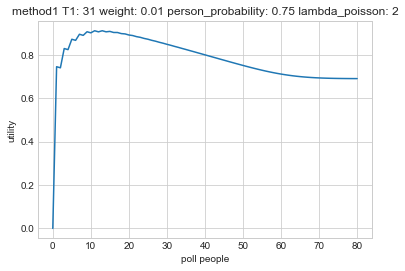

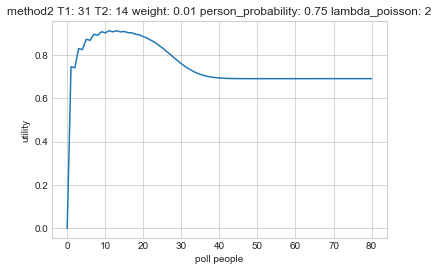

In [25]:
w = 0.01
p = 0.75
lambda_poisson = 2

# plot_poisson(10, lambda_poisson)
# plot_gamma(30, lambda_poisson)
# plot_g(30, 40, 20, lambda_poisson)

# plot_time_priority(w, p, lambda_poisson, 0, 100) # with Decimal
# plot_poll_priority(w, p, lambda_poisson, 0, 200)
# plot_vote_priority(w, p, lambda_poisson, 0, 150)
# plot_method1(w, p, lambda_poisson, 0, 80)
# plot_method2(w, p, lambda_poisson, 0, 80)

In [15]:
@lru_cache(maxsize=None)
def poisson_probability(n, t, lambda_poisson):
    return math.e**(-lambda_poisson * t) * (lambda_poisson * t)**n / math.factorial(n)

@lru_cache(maxsize=None)
def gamma_probability(n, t, lambda_poisson):
    return lambda_poisson**n * t**(n - 1) * math.e**(-lambda_poisson * t) / math.factorial(n - 1)

@lru_cache(maxsize=None)
def g(m, n, t, T, lambda_poisson):
    return lambda_poisson**n * t**(m - 1) * (T - t)**(n - m) * math.e**(-lambda_poisson * T) / (math.factorial(m - 1) * math.factorial(n - m))

### theory_with_decimal.py

In [12]:
@lru_cache(maxsize=None)
def poisson_probability(n, t, lambda_poisson):
    return float(Decimal(math.e)**(-Decimal(lambda_poisson) * Decimal(t)) * (Decimal(lambda_poisson) * Decimal(t))**Decimal(n) / Decimal(math.factorial(n)))

@lru_cache(maxsize=None)
def gamma_probability(n, t, lambda_poisson):
    return float(Decimal(lambda_poisson)**n * Decimal(t)**(n - 1) * Decimal(math.e)**(-Decimal(lambda_poisson) * Decimal(t)) / math.factorial(n - 1))

@lru_cache(maxsize=None)
def g(m, n, t, T, lambda_poisson):
    return float(Decimal(lambda_poisson)**Decimal(n) * Decimal(t**(m - 1)) * Decimal((T - t)**(n - m)) * Decimal(math.e)**(-Decimal(lambda_poisson) * Decimal(T)) / (math.factorial(Decimal(m - 1)) * math.factorial(Decimal(n - m))))

In [ ]:
w = 0.01
p = 0.6
lambda_poisson = 5
print "a"
plot_g(10, 45, 5, lambda_poisson)

# arr_2 = range(0, 16)

# plot_time_priority(w, p, lambda_poisson, 0, 50)
# plot_poll_priority(w, p, lambda_poisson, 0, 50)
# plot_vote_priority(w, p, lambda_poisson, 0, 50)

# fundamental_df = pd.DataFrame({
#     'A: time_priority': [time_priority_method(int(t), w, p, lambda_poisson) for t in arr_2],
#     'B: poll_priority': [poll_priority_method(n, w, p, lambda_poisson) for n in arr_2],
#     'C: vote_priority': [vote_priority_method(k, w, p, lambda_poisson) for k in arr_2]
# })
# fundamental_df.style.highlight_max()

------------- Plot graph ---------------


OverflowError: (34, 'Result too large')

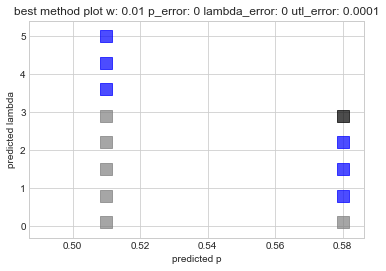

In [12]:
print "------------- Plot graph ---------------"
w = 0.01
p = 0.6

@lru_cache(maxsize=None)
def plot_best_method(w, p_error, lambda_error, utl_error):
    color_list = []
    lambda_range = np.linspace(0.1, 5, 8)
    p_range = np.linspace(0.51, 1.0, 8)
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.set_title('best method plot w: {0} p_error: {1} lambda_error: {2} utl_error: {3}'.format(w, p_error, lambda_error, utl_error))
    ax.set_xlabel('predicted p')
    ax.set_ylabel('predicted lambda')
    for p_i in range(len(p_range)):
        for l_i in range(len(lambda_range)):
            max_utility_dict = {
                "red": max_time_priority_with_error(w, p_range[p_i], p_error, lambda_range[l_i], lambda_error),
                "yellow": max_poll_priority_with_error(w, p_range[p_i], p_error, lambda_range[l_i], lambda_error),
                "blue": max_vote_priority_with_error(w, p_range[p_i], p_error, lambda_range[l_i], lambda_error),
                "gray": max_method2_with_error(w, p_range[p_i], p_error, lambda_range[l_i], lambda_error)[0],
                "black": max_method3_with_error(w, p_range[p_i], p_error, lambda_range[l_i], lambda_error, utl_error)
            }
            ax.scatter(p_range[p_i], lambda_range[l_i], marker='s', s=150, c=max(max_utility_dict.items(), key=lambda x:x[1])[0], alpha=0.7)
    fig.show()

%time plot_best_method(0.01, 0,  0, 0.0001)


### find max utility

In [ ]:
w = 0.01
p = 0.6
lambda_poisson = 2
p_error = 0
lambda_poisson_error = 2

print "------------時間優先------------"
%time print max_time_priority(w, p , lambda_poisson)
%time print max_time_priority_with_error(w, p , 0, lambda_poisson, 0)
print "------------投票数優先------------"
%time print max_poll_priority(w,  p, lambda_poisson)
%time print poll_priority_method(inc_and_dec_poll_priority_method(w, p, lambda_poisson), w, p, lambda_poisson)
%time print max_poll_priority_with_error(w, p , 0, lambda_poisson, 0)
print "------------得票数優先------------"# 91.6ms 0.936263434486
%time print max_vote_priority(w, p, lambda_poisson)
%time print max_vote_priority_with_error(w, p , 0, lambda_poisson, 0)
print "------------method2------------"
%time print max_method2(1, 30, w,  p, lambda_poisson)
%time print max_method2_with_error(1, 30, w, p , 0, lambda_poisson, 0)
print "------------method3------------"
%time print max_method3(25, 27, w,  p, lambda_poisson)
%time print max_method3_with_error(25, 27, w,  p, 0, lambda_poisson, 0)

In [ ]:
w = 0.01
p = 0.6
lambda_poisson = 4

arr = range(0, 10)

m2_df = pd.DataFrame({
    'a1': [method2(1, n, w, p, lambda_poisson) for n in arr],
    'b2': [method2(2, n, w, p, lambda_poisson) for n in arr],
    'c3': [method2(3, n, w, p, lambda_poisson) for n in arr],
    'd4': [method2(4, n, w, p, lambda_poisson) for n in arr],
    'e5': [method2(5, n, w, p, lambda_poisson) for n in arr],
    'f6': [method2(6, n, w, p, lambda_poisson) for n in arr],
    'g7': [method2(7, n, w, p, lambda_poisson) for n in arr],
    'h8': [method2(8, n, w, p, lambda_poisson) for n in arr],
    'i9': [method2(9, n, w, p, lambda_poisson) for n in arr],
    'j10': [method2(10, n, w, p, lambda_poisson) for n in arr],
    'k11': [method2(11, n, w, p, lambda_poisson) for n in arr],
    'l12': [method2(12, n, w, p, lambda_poisson) for n in arr],
    'm13': [method2(13, n, w, p, lambda_poisson) for n in arr],
    'n14': [method2(14, n, w, p, lambda_poisson) for n in arr],
    'o15': [method2(15, n, w, p, lambda_poisson) for n in arr],
    'p18': [method2(18, n, w, p, lambda_poisson) for n in arr],
    'q21': [method2(21, n, w, p, lambda_poisson) for n in arr],
    'r24': [method2(24, n, w, p, lambda_poisson) for n in arr],
    's27': [method2(27, n, w, p, lambda_poisson) for n in arr],
    't30': [method2(30, n, w, p, lambda_poisson) for n in arr],
})

In [ ]:
m2_df.style.highlight_max()

In [ ]:
arr = range(0, 3)

w = 0.01
p = 0.6
lambda_poisson = 1
T1 = 30

m3_df = pd.DataFrame({
    'a1': [method3(T1,1, n, w, p, lambda_poisson) for n in arr],
    'b2': [method3(T1,2, n, w, p, lambda_poisson) for n in arr],
    'c3': [method3(T1,3, n, w, p, lambda_poisson) for n in arr],
    'd4': [method3(T1,4, n, w, p, lambda_poisson) for n in arr],
    'e5': [method3(T1,5, n, w, p, lambda_poisson) for n in arr],
    'f6': [method3(T1,6, n, w, p, lambda_poisson) for n in arr],
    'g7': [method3(T1,7, n, w, p, lambda_poisson) for n in arr],
    'h8': [method3(T1,8, n, w, p, lambda_poisson) for n in arr],
    'i9': [method3(T1,9, n, w, p, lambda_poisson) for n in arr],
    'j10': [method3(T1,10, n, w, p, lambda_poisson) for n in arr],
    'k11': [method3(T1,11, n, w, p, lambda_poisson) for n in arr],
    'l12': [method3(T1,12, n, w, p, lambda_poisson) for n in arr],
    'm13': [method3(T1,13, n, w, p, lambda_poisson) for n in arr],
    'n14': [method3(T1,14, n, w, p, lambda_poisson) for n in arr],
    'o15': [method3(T1,15, n, w, p, lambda_poisson) for n in arr],
    'p16': [method3(T1,16, n, w, p, lambda_poisson) for n in arr],
    'q24': [method3(T1,24, n, w, p, lambda_poisson) for n in arr],
    'r26': [method3(T1,26, n, w, p, lambda_poisson) for n in arr],
    's28': [method3(T1,28, n, w, p, lambda_poisson) for n in arr],
    't30': [method3(T1,30, n, w, p, lambda_poisson) for n in arr],
})

In [ ]:
m3_df.style.highlight_max()

In [ ]:
np.linspace(0.51, 0.99, 7)

### テスト

In [40]:
p = 0.6
lambda_poisson = 0.1
T1 = 10
T2 = 5

# integrate g and poisson should be same
def test_f(t):
    return g(4,10,t,5,2)
value, abserr = integrate.quad(test_f, 0, 5)
print "integrate g and poisson should be same."
print value
print poisson_probability(10,5,2)
print "--------------------------------------------------"

# time_priotity_method probability sum should be 1.0
def time_priotity_method_probability_sum(t, lambda_poisson):
        return np.sum(poisson_probability(i, t, lambda_poisson) for i in range(1, 150))
print "time_priotity_method probability sum should be 1.0."
print time_priotity_method_probability_sum(20, lambda_poisson)
print "--------------------------------------------------"

# poll_priority_method probabilty sum should be 1.0
def poll_priotity_method_probability_sum(n, lambda_poisson):
    return integrate.quad(lambda t: gamma_probability(n, t, lambda_poisson), 0, np.inf)[0]
print "poll_priority_method probabilty sum should be 1.0."
print poll_priotity_method_probability_sum(20, lambda_poisson)
print "--------------------------------------------------"

# vote_priority_method probabilty sum should be 1.0
def vote_priotity_method_probability_sum(k, p, lambda_poisson):
    return np.sum((scm.comb(j - 1, j - k) * p**(k - 1) * (1 - p)**(j - k) * p) + (scm.comb(j - 1, j - k) * p**(j - k) * (1 - p)**(k - 1) * (1 - p)) for j in range(k, 2 * k))
print "vote_priority_method probabilty sum should be 1.0."
print vote_priotity_method_probability_sum(20, p, lambda_poisson)
print "--------------------------------------------------"

# method1 probability sum should be 1.0
def method1_probability_sum(T1, n, lambda_poisson):
    p_sum = 0
    for i in range(0, n):
        p_sum += poisson_probability(i, T1, lambda_poisson)
    # 積分を行う
    value, abserr = integrate.quad(lambda t: gamma_probability(n, t, lambda_poisson), 0, T1)
    p_sum += value
    return p_sum
print "method1 probability sum should be 1.0."
print method1_probability_sum(T1, 10, lambda_poisson)
print "--------------------------------------------------"

# method2 probability sum should be 1.0
def method2_probability_sum(T1, T2, n, lambda_poisson):
    p_sum = 0
    for i in range(0, n):
        p_sum += poisson_probability(i, T1, lambda_poisson)
    for i in range(n, 100):
        value_1, abserr = integrate.quad(lambda t: g(n, i, t, T1, lambda_poisson), 0, T2)
        value_2, abserr = integrate.quad(lambda t: g(n, i, t, T1, lambda_poisson), T2, T1)
        p_sum += value_1
        p_sum += value_2
    return p_sum
print "method2 probability sum should be 1.0."
print method2_probability_sum(T1, T2, 10, lambda_poisson)
print "--------------------------------------------------"


integrate g and poisson should be same.
0.125110035721
1.63226162196e-10
--------------------------------------------------
time_priotity_method probability sum should be 1.0.
0.864664716763
--------------------------------------------------
poll_priority_method probabilty sum should be 1.0.
1.0
--------------------------------------------------
vote_priority_method probabilty sum should be 1.0.
1.0
--------------------------------------------------
method1 probability sum should be 1.0.
1.0
--------------------------------------------------
method2 probability sum should be 1.0.
1.0
--------------------------------------------------
